In [2]:
import sklearn.datasets as skd
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from scipy.sparse import vstack
import matplotlib.pyplot as plt

In [4]:
train_data = skd.load_files('datasets/20news-bydate/20news-bydate-train', encoding='ISO-8859-1')

test_data = skd.load_files('datasets/20news-bydate/20news-bydate-test', encoding='ISO-8859-1')

In [37]:
# count vectorization
count_vk = CountVectorizer()
X_train_tf = count_vk.fit_transform(train_data.data)
X_test_tf = count_vk.transform(test_data.data)

In [38]:
tf = TfidfTransformer()
X_train_tfidf = tf.fit_transform(X_train_tf)
print('Shape of X_train_tfidf', X_train_tfidf.shape)

Shape of X_train_tfidf (11314, 130107)


In [39]:
split_ratio = 0.1 # labeled vs unlabeled
X_l, X_u, y_l, y_u = train_test_split(X_train_tfidf, train_data.target, train_size=split_ratio, stratify=train_data.target)
print(X_l.shape, X_u.shape)

(1131, 130107) (10183, 130107)


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [40]:
def semiSupFit(X_l, y_l, X_u):
    n_ul_docs = X_u.shape[0] # number of unlabeled samples
    n_l_docs = X_l.shape[0] # number of labeled samples
    alpha = 1e-2
    clf = MultinomialNB(alpha=alpha)
    clf.fit(X_l, y_l) # use labeled data only to initialize classifier parameters

    theta_wt_cj = clf.feature_log_prob_ # log CP of word given class [n_classes, n_words]
    theta_cj = clf.class_log_prior_
    prev_theta_wt_cj = np.zeros(theta_wt_cj.shape) - np.inf # log CP of word given class [n_classes, n_words]
    prev_theta_cj = np.zeros(theta_cj.shape) - np.inf
    diff_wt_cj = np.sum(theta_wt_cj-prev_theta_wt_cj)
    diff_cj = np.sum(theta_cj-prev_theta_cj)
    totalDiff = diff_wt_cj+diff_cj
    print("diff_wt_cj:",diff_wt_cj,"diff_cj:",diff_cj,'totalDiff:',totalDiff)

    iter_count = 0 # count EM iteration
    max_iter=30
    while (totalDiff!=0 and iter_count<max_iter):
        iter_count += 1
        print("EM iteration #%d" % iter_count) # debug
        # E-step: Estimate class membership of unlabeled documents
        y_u = clf.predict(X_u)
        # M-step: Re-estimate classifier parameters
        X = vstack([X_l, X_u])
        y = np.concatenate((y_l, y_u), axis=0)
        clf.fit(X, y)
        
        theta_wt_cj = clf.feature_log_prob_ # log CP of word given class [n_classes, n_words]
        theta_cj = clf.class_log_prior_

        diff_wt_cj = np.sum(theta_wt_cj-prev_theta_wt_cj)
        diff_cj = np.sum(theta_cj-prev_theta_cj)
        totalDiff = diff_wt_cj+diff_cj
        print("diff_wt_cj:",diff_wt_cj,"diff_cj:",diff_cj,'totalDiff:',totalDiff)
        prev_theta_wt_cj = theta_wt_cj
        prev_theta_cj = theta_cj

    return clf

In [41]:
# Train Naive Bayes classifier (imported) 
# using labeled data set only
cv_clf = MultinomialNB(alpha=1e-2)
cv_clf.fit(X_l, y_l)
predicted = cv_clf.predict(X_test_tf)
accuracy = accuracy_score(test_data.target, predicted) * 100
print("MultinomialNB Accuracy is {0:0.3f} %".format(accuracy))

# Training based on EM algorithm 
# using labeled data set only
cv_clf = semiSupFit(X_l, y_l, X_u)
predicted = cv_clf.predict(X_test_tf)
accuracy = accuracy_score(test_data.target, predicted) * 100
print("EM algo Accuracy is {0:0.3f} %".format(accuracy))

MultinomialNB Accuracy is 64.379 %
diff_wt_cj: inf diff_cj: inf totalDiff: inf
EM iteration #1
diff_wt_cj: inf diff_cj: inf totalDiff: inf
EM iteration #2
diff_wt_cj: -5502.317227407562 diff_cj: 0.0027905725825307925 totalDiff: -5502.3144368349795
EM iteration #3
diff_wt_cj: -759.1325222998217 diff_cj: -0.00031338782635259577 totalDiff: -759.1328356876481
EM iteration #4
diff_wt_cj: -185.39398829063575 diff_cj: 0.0003952246612808352 totalDiff: -185.39359306597447
EM iteration #5
diff_wt_cj: -54.31091127967875 diff_cj: -9.624071395908373e-05 totalDiff: -54.31100752039271
EM iteration #6
diff_wt_cj: -27.383903705523263 diff_cj: 7.80648300260367e-05 totalDiff: -27.38382564069324
EM iteration #7
diff_wt_cj: -31.154129910199366 diff_cj: 7.425113450487686e-05 totalDiff: -31.15405565906486
EM iteration #8
diff_wt_cj: -28.827023827057236 diff_cj: 7.043828799879748e-05 totalDiff: -28.826953388769237
EM iteration #9
diff_wt_cj: -139.02206767712693 diff_cj: 0.0009626782292979641 totalDiff: -139.0

In [43]:
splitRatios = [0.01,0.02,0.04,0.08,0.16,0.32,0.64]
iterations = []
iterations = []
NBaccuracy = []
EMaccuracy = []

for iteration, split_ratio in enumerate(splitRatios):
    iterations.append(iteration+1)
    
    #split_ratio = 0.1 # labeled vs unlabeled
    X_l, X_u, y_l, y_u = train_test_split(X_train_tfidf, train_data.target, train_size=split_ratio, stratify=train_data.target)
    # Train Naive Bayes classifier (imported) 
    # using labeled data set only
    cv_clf = MultinomialNB(alpha=1e-2)
    cv_clf.fit(X_l, y_l)
    predicted = cv_clf.predict(X_test_tf)
    accuracy = accuracy_score(test_data.target, predicted) * 100
    print("MultinomialNB Accuracy is {0:0.3f} %".format(accuracy))
    NBaccuracy.append(accuracy)

    # Training based on EM algorithm 
    # using labeled data set only
    cv_clf = semiSupFit(X_l, y_l, X_u)
    predicted = cv_clf.predict(X_test_tf)
    accuracy = accuracy_score(test_data.target, predicted) * 100
    print("EM algo Accuracy is {0:0.3f} %".format(accuracy))
    EMaccuracy.append(accuracy)
    
    
print('NBaccuracy:',NBaccuracy)
print('EMaccuracy:',EMaccuracy)

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


MultinomialNB Accuracy is 26.009 %
diff_wt_cj: inf diff_cj: inf totalDiff: inf
EM iteration #1
diff_wt_cj: inf diff_cj: inf totalDiff: inf
EM iteration #2
diff_wt_cj: -53002.41165508014 diff_cj: 0.1896965734369358 totalDiff: -53002.22195850671
EM iteration #3
diff_wt_cj: -15987.391443257558 diff_cj: -0.09124233045576613 totalDiff: -15987.482685588015
EM iteration #4
diff_wt_cj: -8522.995841928385 diff_cj: -0.07113640023762269 totalDiff: -8523.066978328623
EM iteration #5
diff_wt_cj: -4824.277384807567 diff_cj: 0.013643223621227385 totalDiff: -4824.263741583945
EM iteration #6
diff_wt_cj: -2029.2881533190136 diff_cj: 0.0017277166924190013 totalDiff: -2029.2864256023213
EM iteration #7
diff_wt_cj: -820.5550000082848 diff_cj: -0.012603766762779856 totalDiff: -820.5676037750476
EM iteration #8
diff_wt_cj: -1732.223359502712 diff_cj: 0.007181317200458892 totalDiff: -1732.2161781855114
EM iteration #9
diff_wt_cj: 265.5756504378295 diff_cj: -0.020160572044077618 totalDiff: 265.55548986578543


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


MultinomialNB Accuracy is 33.510 %
diff_wt_cj: inf diff_cj: inf totalDiff: inf
EM iteration #1
diff_wt_cj: inf diff_cj: inf totalDiff: inf
EM iteration #2
diff_wt_cj: -33532.86655146251 diff_cj: -0.1759845901494339 totalDiff: -33533.04253605266
EM iteration #3
diff_wt_cj: -10026.307925217274 diff_cj: -0.07742570440889818 totalDiff: -10026.385350921682
EM iteration #4
diff_wt_cj: -3492.524802048602 diff_cj: -0.0382998554577636 totalDiff: -3492.5631019040597
EM iteration #5
diff_wt_cj: -1705.6066692645463 diff_cj: -0.0556483431772401 totalDiff: -1705.6623176077235
EM iteration #6
diff_wt_cj: -517.7957506846097 diff_cj: -0.062385934031115475 totalDiff: -517.8581366186409
EM iteration #7
diff_wt_cj: -946.8529456781135 diff_cj: 0.007205321759983008 totalDiff: -946.8457403563535
EM iteration #8
diff_wt_cj: -1832.5627014059446 diff_cj: 0.015788151332994715 totalDiff: -1832.5469132546116
EM iteration #9
diff_wt_cj: -595.1667655260512 diff_cj: 0.005238476587664742 totalDiff: -595.1615270494635


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


diff_wt_cj: inf diff_cj: inf totalDiff: inf
EM iteration #2
diff_wt_cj: -22827.82561607779 diff_cj: 0.129307561903647 totalDiff: -22827.696308515886
EM iteration #3
diff_wt_cj: -5016.979984344413 diff_cj: 0.031896161938031575 totalDiff: -5016.948088182476
EM iteration #4
diff_wt_cj: -1555.8994517671122 diff_cj: 0.00841202991310741 totalDiff: -1555.891039737199
EM iteration #5
diff_wt_cj: -1394.6030016025938 diff_cj: 0.012103446623866532 totalDiff: -1394.59089815597
EM iteration #6
diff_wt_cj: -457.6349149313674 diff_cj: 0.0036132963275203878 totalDiff: -457.6313016350399
EM iteration #7
diff_wt_cj: -193.87280099642769 diff_cj: 0.0019178253658047595 totalDiff: -193.87088317106188
EM iteration #8
diff_wt_cj: 0.0 diff_cj: 0.0 totalDiff: 0.0
EM algo Accuracy is 61.816 %


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


MultinomialNB Accuracy is 61.498 %
diff_wt_cj: inf diff_cj: inf totalDiff: inf
EM iteration #1
diff_wt_cj: inf diff_cj: inf totalDiff: inf
EM iteration #2
diff_wt_cj: -5836.514586011431 diff_cj: -0.01719762151538795 totalDiff: -5836.531783632946
EM iteration #3
diff_wt_cj: -769.6135858584519 diff_cj: -0.00233860167310862 totalDiff: -769.615924460125
EM iteration #4
diff_wt_cj: -439.237848388344 diff_cj: 0.002549042115271405 totalDiff: -439.2352993462287
EM iteration #5
diff_wt_cj: 0.0 diff_cj: 0.0 totalDiff: 0.0
EM algo Accuracy is 70.273 %
MultinomialNB Accuracy is 70.512 %
diff_wt_cj: inf diff_cj: inf totalDiff: inf
EM iteration #1


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


diff_wt_cj: inf diff_cj: inf totalDiff: inf
EM iteration #2
diff_wt_cj: -2480.1733808625904 diff_cj: -0.00040570308104559416 totalDiff: -2480.1737865656714
EM iteration #3
diff_wt_cj: 194.4361027754329 diff_cj: -0.004937640155284306 totalDiff: 194.4311651352776
EM iteration #4
diff_wt_cj: 154.04333472903028 diff_cj: -0.002394617386370257 totalDiff: 154.04094011164392
EM iteration #5
diff_wt_cj: 0.0 diff_cj: 0.0 totalDiff: 0.0
EM algo Accuracy is 75.544 %


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


MultinomialNB Accuracy is 74.774 %
diff_wt_cj: inf diff_cj: inf totalDiff: inf
EM iteration #1
diff_wt_cj: inf diff_cj: inf totalDiff: inf
EM iteration #2
diff_wt_cj: -888.3467721833256 diff_cj: 0.004522257293924525 totalDiff: -888.3422499260316
EM iteration #3
diff_wt_cj: -28.021149420133206 diff_cj: 2.5168946554465776e-05 totalDiff: -28.021124251186652
EM iteration #4
diff_wt_cj: 0.0 diff_cj: 0.0 totalDiff: 0.0
EM algo Accuracy is 78.200 %
MultinomialNB Accuracy is 80.589 %
diff_wt_cj: inf diff_cj: inf totalDiff: inf
EM iteration #1


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


diff_wt_cj: inf diff_cj: inf totalDiff: inf
EM iteration #2
diff_wt_cj: -65.26325575546298 diff_cj: 8.364755171896832e-05 totalDiff: -65.26317210791126
EM iteration #3
diff_wt_cj: 0.0 diff_cj: 0.0 totalDiff: 0.0
EM algo Accuracy is 81.373 %
NBaccuracy: [26.009028146574614, 33.51035581518853, 46.25597450876261, 61.49761019649495, 70.5124800849708, 74.77429633563463, 80.5894848645778]
EMaccuracy: [42.64471587891662, 52.681890600106215, 61.8162506638343, 70.27349973446628, 75.54434413170472, 78.19968135953266, 81.37280934678705]


NBaccuracy: [26.009028146574614, 33.51035581518853, 46.25597450876261, 61.49761019649495, 70.5124800849708, 74.77429633563463, 80.5894848645778]
EMaccuracy: [42.64471587891662, 52.681890600106215, 61.8162506638343, 70.27349973446628, 75.54434413170472, 78.19968135953266, 81.37280934678705]
iterations: [1, 2, 3, 4, 5, 6, 7]
splitRatios: [0.01, 0.02, 0.04, 0.08, 0.16, 0.32, 0.64]


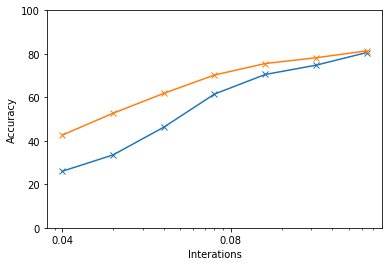

In [74]:
print('NBaccuracy:',NBaccuracy)
print('EMaccuracy:',EMaccuracy)
print('iterations:',iterations)
print('splitRatios:',splitRatios)
#plt.plot(x, x, label='linear')
#plt.plot(x, x**2, label='quadratic')
#plt.plot(x, x**3, label='cubic')
#splitRatios
plt.ylim(0, 100)
plt.plot(splitRatios, NBaccuracy, label='NBaccuracy',marker='x')
plt.plot(splitRatios, EMaccuracy, label='EMaccuracy',marker='x')

#ax.set_yticklabels(y_labels)
#plt.plot( 'x', 'y1', data=NBaccuracy, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)
plt.xlabel('Interations')
plt.ylabel('Accuracy')
ax = plt.gca()
ax.set_xscale('log')
#ax.set_xtick(np.log(splitRatios))
ax.set_xticklabels(splitRatios)
plt.show()